## Threshold for condition:
We want to decide wether a problem is unique or non unique depending on this threshold.

### Non uniqueness

 We choose the threshoold $T$ as 
 $$T = \frac{\tilde{\sigma}_1}{\sqrt{E}} $$
where $E = m(C_m \frac{\epsilon}{h} + h^{order} M C_a)^2 + \|u-\tilde{u}\|_2^2$ and $\epsilon = \|u-u_{noise}\|_{\infty} + 10^{-16}$ and $h=dx$. If a value is bigger than T the function u should be nonunique.

In [1]:
import numpy as np
from numpy.linalg import matrix_rank, svd
import sys
sys.path.append('../')
from test_data import experiment_data,add_noise,create_data_2d
import pysindy as ps
import matplotlib.pyplot as plt
from error_bounds import *

In [2]:
def calc_threshold(eps,h,number_datapoints,order=2):
    eps+=np.finfo(float).eps # add machine precisoin
    if order%2==0: #even order
        C_meas=meas_error_central_diff(order)
    else: # odd order
        C_meas=meas_error_backward_diff(order)
    return 1/(eps/h+h**order)

def calc_threshold2(omax,eps_two,eps_infty,h,number_datapoints,M,order=2): 
    E = error_bound_g(eps_two,eps_infty,h,number_datapoints,M,order)
    return omax/np.sqrt(E)

In [3]:
n_samples=50
T,X,t,x = create_data_2d(T_start=-5, T_end=1, L_x_start=0,L_x_end=1, N_t=n_samples, N_x=n_samples)
a=np.random.randn()

u = np.exp(X-a*T)
ux = u
uxx = u
uxxx = u
ut = -a*u

dx=x[1]-x[0]

In [4]:
u_flat, ux_flat = u.flatten(), ux.flatten()
true_g = np.concatenate([u_flat.reshape(len(u_flat),1), ux_flat.reshape(len(ux_flat),1)], axis=1)
sv = svd(true_g, compute_uv=False)
sv_max,sv_min=sv[0],sv[-1]
print(f"M: {np.max(u)}")
print(f"Singular values of g: {sv_max,sv_min}")
print(f"sv_max/sv_min: {sv_max/sv_min:3.3e}")

M: 5.0614390588702145
Singular values of g: (88.82065069391868, 1.1455913258292531e-14)
sv_max/sv_min: 7.753e+15


In [5]:
u_flat, ux_flat = u.flatten(), ux.flatten()
true_g = np.concatenate([u_flat.reshape(len(u_flat),1), ux_flat.reshape(len(ux_flat),1)], axis=1)
sv = svd(true_g, compute_uv=False)
sv_max,sv_min=sv[0],sv[-1]
print(f"M: {np.max(u)}")
print(f"Singular values of g: {sv_max,sv_min}")
print(f"sv_max/sv_min: {sv_max/sv_min:3.3e}")

M: 5.0614390588702145
Singular values of g: (88.82065069391868, 1.1455913258292531e-14)
sv_max/sv_min: 7.753e+15


True ratio: 7.753e+15
Noise level 	 order 	 	 ratio 	 	 threshold 	 threshold2
0
0.0
	  	 2 	 	 4.352e+04 	 2.401e+03 	 5.056e+03
	  	 3 	 	 4.214e+06 	 1.176e+05 	 1.652e+05
	  	 4 	 	 2.803e+08 	 5.765e+06 	 6.070e+07
	  	 5 	 	 1.416e+10 	 2.825e+08 	 5.948e+08
	  	 6 	 	 8.505e+11 	 1.384e+10 	 6.749e+11
	  	 7 	 	 4.479e+13 	 6.733e+11 	 1.239e+12
	  	 8 	 	 4.480e+13 	 2.441e+13 	 7.754e+13
	  	 9 	 	 2.890e+13 	 8.700e+13 	 1.210e+12


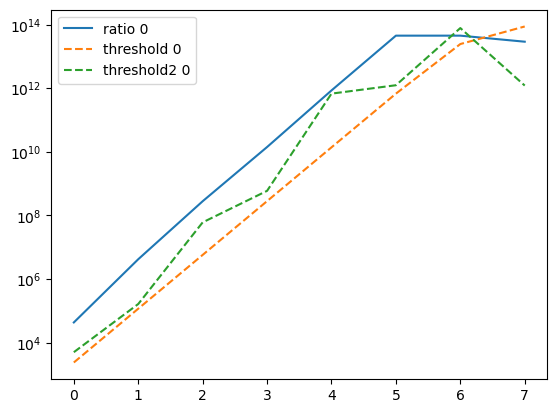

Noise level 	 order 	 	 ratio 	 	 threshold 	 threshold2
1e-10
6.296527491274901e-09
	  	 2 	 	 4.352e+04 	 2.401e+03 	 5.056e+03
	  	 3 	 	 4.219e+06 	 1.174e+05 	 1.631e+05
	  	 4 	 	 2.107e+08 	 5.163e+06 	 2.980e+07
	  	 5 	 	 2.068e+08 	 4.208e+07 	 5.103e+06
	  	 6 	 	 1.553e+08 	 4.927e+07 	 4.791e+07
	  	 7 	 	 1.030e+08 	 4.944e+07 	 1.909e+06
	  	 8 	 	 6.480e+07 	 4.945e+07 	 4.216e+07
	  	 9 	 	 3.845e+07 	 4.945e+07 	 6.511e+05


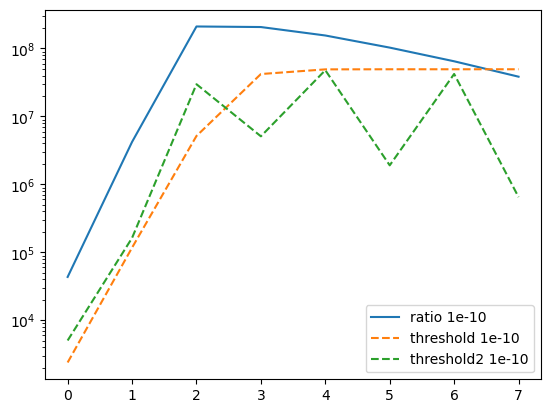

Noise level 	 order 	 	 ratio 	 	 threshold 	 threshold2
1e-09
6.208695315987516e-08
	  	 2 	 	 4.352e+04 	 2.400e+03 	 5.053e+03
	  	 3 	 	 4.179e+06 	 1.148e+05 	 1.460e+05
	  	 4 	 	 2.668e+07 	 2.596e+06 	 5.120e+06
	  	 5 	 	 1.907e+07 	 4.644e+06 	 4.910e+05
	  	 6 	 	 1.406e+07 	 4.720e+06 	 4.575e+06
	  	 7 	 	 9.347e+06 	 4.721e+06 	 1.822e+05
	  	 8 	 	 5.904e+06 	 4.721e+06 	 4.026e+06
	  	 9 	 	 3.510e+06 	 4.721e+06 	 6.217e+04


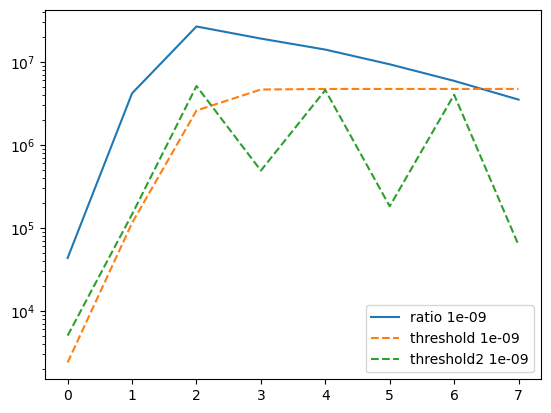

Noise level 	 order 	 	 ratio 	 	 threshold 	 threshold2
1e-08
6.312343381840467e-07
	  	 2 	 	 4.349e+04 	 2.389e+03 	 5.026e+03
	  	 3 	 	 2.397e+06 	 9.441e+04 	 7.190e+04
	  	 4 	 	 2.688e+06 	 4.413e+05 	 5.607e+05
	  	 5 	 	 1.929e+06 	 4.771e+05 	 4.974e+04
	  	 6 	 	 1.414e+06 	 4.779e+05 	 4.630e+05
	  	 7 	 	 9.375e+05 	 4.779e+05 	 1.845e+04
	  	 8 	 	 6.010e+05 	 4.779e+05 	 4.075e+05
	  	 9 	 	 3.689e+05 	 4.779e+05 	 6.292e+03


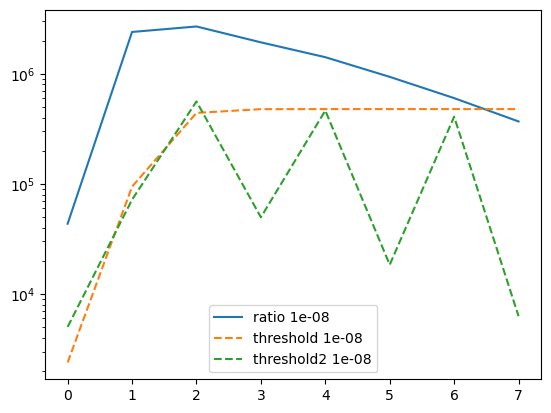

Noise level 	 order 	 	 ratio 	 	 threshold 	 threshold2
1e-07
6.339421295307543e-06
	  	 2 	 	 4.330e+04 	 2.291e+03 	 4.783e+03
	  	 3 	 	 2.777e+05 	 3.503e+04 	 1.230e+04
	  	 4 	 	 2.527e+05 	 4.945e+04 	 5.901e+04
	  	 5 	 	 1.787e+05 	 4.987e+04 	 5.192e+03
	  	 6 	 	 1.296e+05 	 4.988e+04 	 4.833e+04
	  	 7 	 	 8.592e+04 	 4.988e+04 	 1.925e+03
	  	 8 	 	 5.538e+04 	 4.988e+04 	 4.253e+04
	  	 9 	 	 3.450e+04 	 4.988e+04 	 6.568e+02


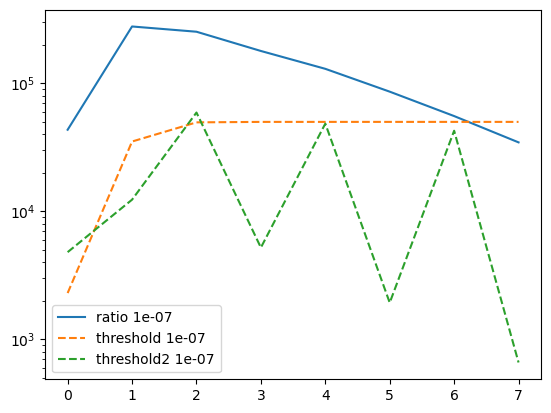

Noise level 	 order 	 	 ratio 	 	 threshold 	 threshold2
1e-06
6.425747275804866e-05
	  	 2 	 	 3.268e+04 	 1.527e+03 	 3.013e+03
	  	 3 	 	 2.802e+04 	 4.051e+03 	 1.111e+03
	  	 4 	 	 2.633e+04 	 4.193e+03 	 4.969e+03
	  	 5 	 	 1.934e+04 	 4.196e+03 	 4.367e+02
	  	 6 	 	 1.451e+04 	 4.196e+03 	 4.066e+03
	  	 7 	 	 9.571e+03 	 4.196e+03 	 1.620e+02
	  	 8 	 	 5.965e+03 	 4.196e+03 	 3.578e+03
	  	 9 	 	 3.541e+03 	 4.196e+03 	 5.525e+01


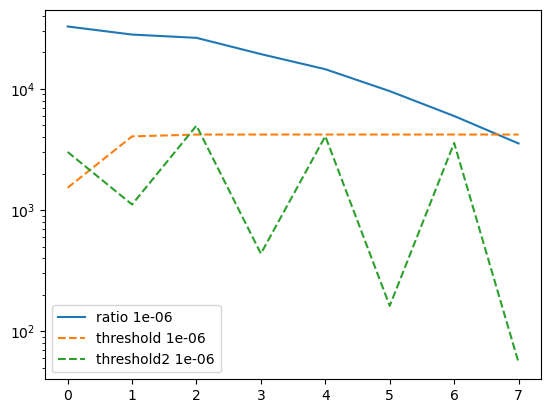

Noise level 	 order 	 	 ratio 	 	 threshold 	 threshold2
1e-05
0.0006275085437402335
	  	 2 	 	 4.660e+03 	 3.464e+02 	 6.295e+02
	  	 3 	 	 2.933e+03 	 4.034e+02 	 1.078e+02
	  	 4 	 	 2.742e+03 	 4.047e+02 	 4.793e+02
	  	 5 	 	 1.966e+03 	 4.048e+02 	 4.213e+01
	  	 6 	 	 1.440e+03 	 4.048e+02 	 3.922e+02
	  	 7 	 	 9.429e+02 	 4.048e+02 	 1.562e+01
	  	 8 	 	 5.936e+02 	 4.048e+02 	 3.451e+02
	  	 9 	 	 3.602e+02 	 4.048e+02 	 5.330e+00


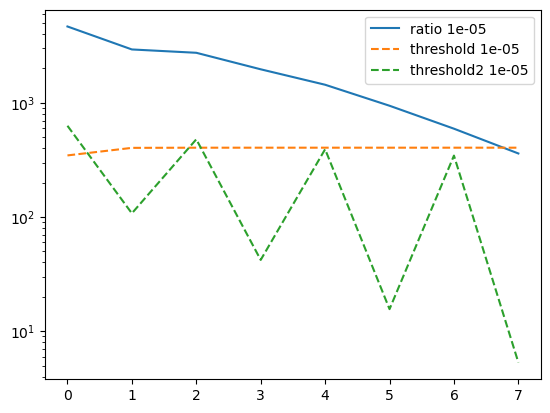

Noise level 	 order 	 	 ratio 	 	 threshold 	 threshold2
0.0001
0.006312329046775236
	  	 2 	 	 4.874e+02 	 4.421e+01 	 7.877e+01
	  	 3 	 	 3.017e+02 	 4.502e+01 	 1.200e+01
	  	 4 	 	 2.887e+02 	 4.504e+01 	 5.334e+01
	  	 5 	 	 2.068e+02 	 4.504e+01 	 4.688e+00
	  	 6 	 	 1.525e+02 	 4.504e+01 	 4.364e+01
	  	 7 	 	 1.001e+02 	 4.504e+01 	 1.739e+00
	  	 8 	 	 6.281e+01 	 4.504e+01 	 3.841e+01
	  	 9 	 	 3.735e+01 	 4.504e+01 	 5.935e-01


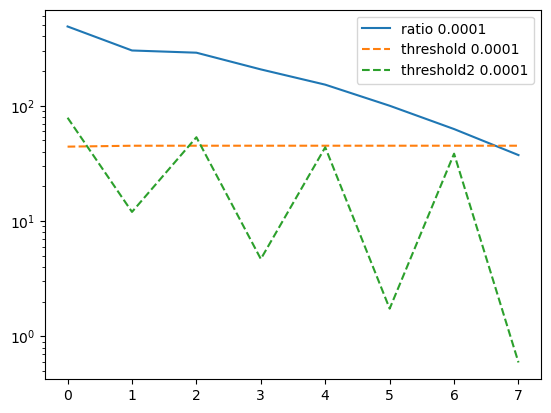

Noise level 	 order 	 	 ratio 	 	 threshold 	 threshold2
0.001
0.06371126746235331
	  	 2 	 	 4.779e+01 	 4.767e+00 	 8.469e+00
	  	 3 	 	 2.931e+01 	 4.776e+00 	 1.273e+00
	  	 4 	 	 2.802e+01 	 4.776e+00 	 5.657e+00
	  	 5 	 	 1.978e+01 	 4.776e+00 	 4.972e-01
	  	 6 	 	 1.439e+01 	 4.776e+00 	 4.631e+00
	  	 7 	 	 9.470e+00 	 4.776e+00 	 1.849e-01
	  	 8 	 	 6.123e+00 	 4.776e+00 	 4.113e+00
	  	 9 	 	 3.907e+00 	 4.776e+00 	 6.499e-02


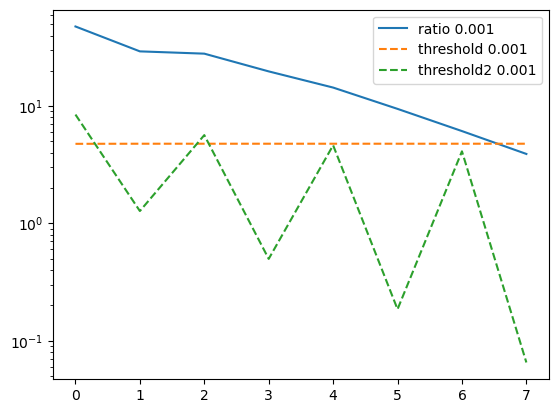

Noise level 	 order 	 	 ratio 	 	 threshold 	 threshold2
0.01
0.6297146570945862
	  	 2 	 	 5.230e+00 	 4.526e-01 	 8.197e-01
	  	 3 	 	 3.406e+00 	 4.527e-01 	 1.273e-01
	  	 4 	 	 3.241e+00 	 4.527e-01 	 5.713e-01
	  	 5 	 	 2.580e+00 	 4.527e-01 	 5.436e-02
	  	 6 	 	 2.424e+00 	 4.527e-01 	 5.873e-01
	  	 7 	 	 2.832e+00 	 4.527e-01 	 3.162e-02
	  	 8 	 	 3.988e+00 	 4.527e-01 	 1.046e+00
	  	 9 	 	 6.217e+00 	 4.527e-01 	 2.582e-02


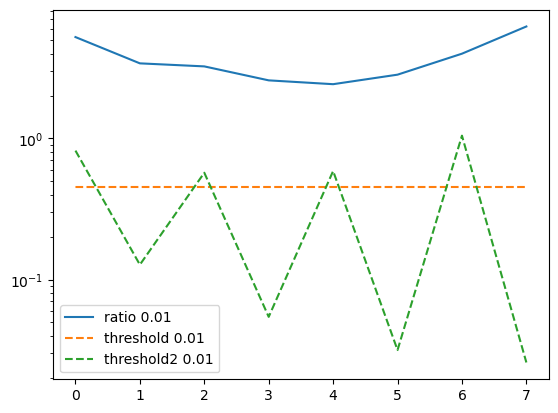

In [6]:
M=infinity_norm(uxxx)
number_noise=10 #<=10
noise_levels = [0]+[10**(-10+i) for i in range(0,number_noise-1)]
orders=range(2,10,1)
print(f"True ratio: {sv_max/sv_min:3.3e}")
unorm2=np.sqrt(np.mean(np.square(u)))

for target_noise in noise_levels:
    print("Noise level \t order \t \t ratio \t \t threshold \t threshold2")
    print(f"{target_noise}")
    threshold_list = []
    threshold2_list = []
    ratio_list=[]
    
    var = target_noise * unorm2
    noise = np.random.normal(0, var, size=u.shape)
    print(np.linalg.norm(noise))
    u_noise = u + noise
    eps_infty = infinity_norm(u-u_noise)
    eps_two = np.linalg.norm(u-u_noise)
    
    for order in orders:          
        ux_noise = ps.FiniteDifference(order=order,d=1, axis=0, drop_endpoints=False)._differentiate(u_noise, dx)
        u_flat_noise, u_x_flat_noise = u_noise.flatten(), ux_noise.flatten()
        g_noise = np.concatenate([u_flat_noise.reshape(len(u_flat_noise),1), u_x_flat_noise.reshape(len(u_flat_noise),1)], axis=1)
        sv = svd(g_noise, compute_uv=False)
        
        ratio=sv[0]/sv[-1]
        threshold = calc_threshold(eps_infty,dx,true_g.shape[0],order)
        threshold_list.append(threshold)
        threshold2 = calc_threshold2(sv[0],eps_two,eps_infty,dx,true_g.shape[0],M,order)
        threshold2_list.append(threshold2)
        ratio_list.append(ratio)
        
        print(f"\t  \t {order} \t \t {ratio:3.3e} \t {threshold:3.3e} \t {threshold2:3.3e}")
    
    plt.plot(ratio_list,label=f'ratio {target_noise}')
    plt.plot(threshold_list,'--',label=f'threshold {target_noise}')
    plt.plot(threshold2_list,'--',label=f'threshold2 {target_noise}')
    plt.yscale('log')
    plt.legend()
    plt.show()

### Uniqueness

##### We try a threshold for unqiue values
We choose $C_1>0$ and $C_2>0$ such that $\sigma_1 \leq C_1 ,\sigma_n \geq \frac{1}{C_2}  $. Then
$$\frac{\tilde\sigma_1}{\tilde\sigma_n} \leq C_1 C_2+ C_2 \sqrt{1 + (C_2 C_1)^2}\|G-\tilde{G}\|_F \leq C_1 C_2+ C_2 \sqrt{1 + (C_2 C_1)^2}\sqrt{E}$$
The ideal $C_1, C_2$ would be $C_1 = \sigma_1, C_2 = \frac{1}{\sigma_n}$. However, in practice we do not know the true singular valuse. Thus, we can educately guess these bounds with:
$$C_1=\tilde\sigma_1+\sqrt{eps/h+h^{order}}, \ C_2=\frac{1}{\tilde\sigma_n-\sqrt{eps/h+h^{order}}}$$
This approximates deviation we get from the derivative calculation.

In [7]:
"""
u: function with noise
eps: noise estimation infinity_norm(u-u_noise)
"""
def educated_guess_c1c2(u,eps,h):
    #Calculate omin omax
    ux= ps.FiniteDifference(order=2,d=1, axis=0, drop_endpoints=False)._differentiate(u, h)
    u_flat, u_x_flat = u.flatten(), ux.flatten()
    g = np.concatenate([u_flat.reshape(len(u_flat),1), u_x_flat.reshape(len(u_flat),1)], axis=1)
    sv = svd(g, compute_uv=False)
    omax,omin = sv[0],sv[-1]
    print(omax,omin)
    #Calculate C1,C2    
    E = (eps/h+h**order)
    C1= omax+ np.sqrt(E)
    assert omin - np.sqrt(E) >0
    C2= 1/(omin - np.sqrt(E))
    return C1,C2

"""
This calculates the threshold with minimal knowlegdede
C1: upper bound o1 <= C1
C2: lower bound on >= 1/C2
eps: noise estimation infinity_norm(u-u_noise)
h: dx
order: order of the derivative caluclation
"""
def calc_threshold_uniq(C1,C2,eps,h,order=2):
    E = (eps/h+h**order)
    T = C1*C2 + C2*np.sqrt(1+ (C1*C2)**2)*np.sqrt(E)
    return T
##This function calculates the threshold with all constants (we do not normally know)
def calc_threshold_uniq2(C1,C2,eps_two,eps_infty,M,h,number_datapoints,order=2):
    E = error_bound_g(eps_two,eps_infty,h,number_datapoints,M,order)
    T = C1*C2 + C2*np.sqrt(1+ (C1*C2)**2)*np.sqrt(E)
    return T

In [8]:
n_samples=100
T,X,t,x = create_data_2d(T_start=0, T_end=1, L_x_start=-2,L_x_end=3, N_t=n_samples, N_x=n_samples)
a=np.random.randn()*1e-6
b=np.random.randn()*1e-3
C=0.1
"""
u = np.cos(X-a*T)*C
ux = -np.sin(X-a*T)*C
uxx = -np.cos(X-a*T)*C
uxxx = np.sin(X-a*T)*C
ut = a*np.sin(X-a*T)*C
"""
"""
u=(X+b*T)*np.exp(a*T)
ux = np.exp(a*T)
uxx= 1
uxxx= 0
ut= b*np.exp(a*T) + a*(X*+b*T)*np.exp(a*T) #bux + aut
"""
u = np.exp(X-a*T)
ux = u
uxx = u
uxxx = u
ut = -a*u

dx=x[1]-x[0]

In [9]:
u_flat, ux_flat = u.flatten(), ux.flatten()
true_g = np.concatenate([u_flat.reshape(len(u_flat),1), ux_flat.reshape(len(ux_flat),1)], axis=1)
sv = svd(true_g, compute_uv=False)
sv_max,sv_min=sv[0],sv[-1]
print(f"M: {np.max(u)}")
print(f"Singular values of g: {sv_max,sv_min}")
print(f"sv_max/sv_min: {sv_max/sv_min:3.3e}")

M: 20.08553903345105
Singular values of g: (916.3932409462524, 3.1887728634227705e-14)
sv_max/sv_min: 2.874e+16


In [10]:
#Best choice C1 C2
C1=sv_max
C2=1/sv_min
print(f"C1: {C1}, C2: {C2}")

C1: 916.3932409462524, C2: 31360026029781.824


True ratio: 2.874e+16
Noise level 	 order 	 	 ratio 	 	 threshold 	 threshold2
0
0.0
916.5333167646943 0.16795309122866145
C1: 916.5333182268938, C2: 5.954095270053176
	  	 2 	 	 5.457e+03 	 7.098e+03 	 3.320e+04
	  	 3 	 	 2.292e+05 	 5.826e+03 	 7.559e+03
	  	 4 	 	 5.918e+06 	 5.540e+03 	 5.471e+03
	  	 5 	 	 1.224e+08 	 5.476e+03 	 5.461e+03
	  	 6 	 	 3.050e+09 	 5.461e+03 	 5.457e+03
	  	 7 	 	 7.532e+10 	 5.458e+03 	 5.457e+03
	  	 8 	 	 1.616e+12 	 5.457e+03 	 5.457e+03
	  	 9 	 	 1.446e+13 	 5.457e+03 	 5.457e+03


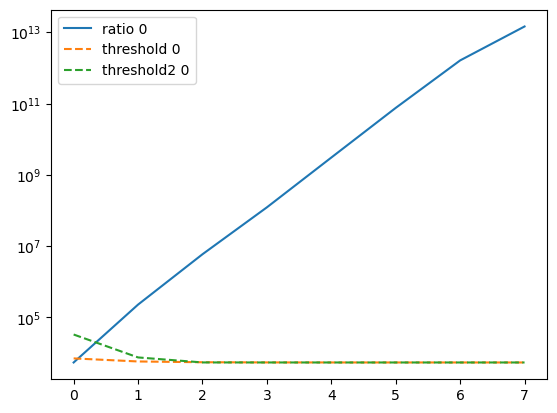

Noise level 	 order 	 	 ratio 	 	 threshold 	 threshold2
1e-10
6.498845037973148e-08
916.5333167524246 0.16795312920140817
C1: 916.533537528506, C2: 5.96187903763821
	  	 2 	 	 5.457e+03 	 7.110e+03 	 3.328e+04
	  	 3 	 	 2.292e+05 	 5.836e+03 	 7.573e+03
	  	 4 	 	 5.915e+06 	 5.555e+03 	 5.479e+03
	  	 5 	 	 1.189e+08 	 5.506e+03 	 5.471e+03
	  	 6 	 	 4.761e+08 	 5.501e+03 	 5.465e+03
	  	 7 	 	 3.207e+08 	 5.501e+03 	 5.472e+03
	  	 8 	 	 2.012e+08 	 5.501e+03 	 5.465e+03
	  	 9 	 	 1.186e+08 	 5.501e+03 	 5.486e+03


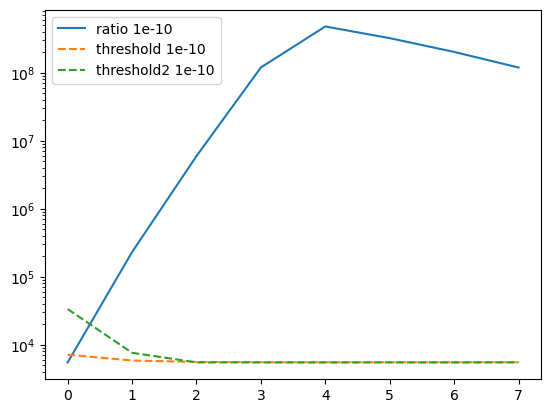

Noise level 	 order 	 	 ratio 	 	 threshold 	 threshold2
1e-09
6.531696480176191e-07
916.5333166694325 0.167953335129409
C1: 916.5340261334891, C2: 5.979292356637122
	  	 2 	 	 5.457e+03 	 7.139e+03 	 3.346e+04
	  	 3 	 	 2.292e+05 	 5.870e+03 	 7.611e+03
	  	 4 	 	 5.901e+06 	 5.625e+03 	 5.497e+03
	  	 5 	 	 5.258e+07 	 5.600e+03 	 5.512e+03
	  	 6 	 	 4.694e+07 	 5.598e+03 	 5.483e+03
	  	 7 	 	 3.228e+07 	 5.598e+03 	 5.556e+03
	  	 8 	 	 2.103e+07 	 5.598e+03 	 5.484e+03
	  	 9 	 	 1.264e+07 	 5.598e+03 	 5.703e+03


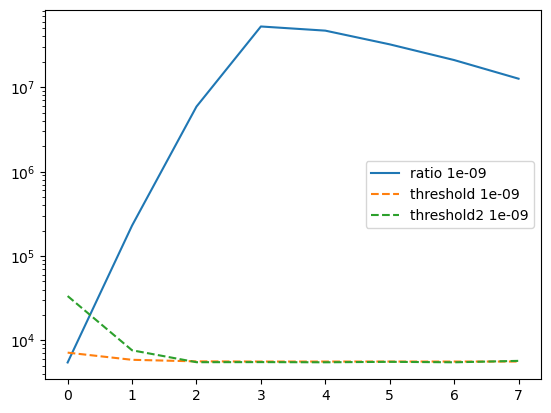

Noise level 	 order 	 	 ratio 	 	 threshold 	 threshold2
1e-08
6.516516138639381e-06
916.5333164750261 0.16795231872818403
C1: 916.5357219121595, C2: 6.040584941050691
	  	 2 	 	 5.457e+03 	 7.268e+03 	 3.411e+04
	  	 3 	 	 2.293e+05 	 6.073e+03 	 7.829e+03
	  	 4 	 	 4.831e+06 	 5.926e+03 	 5.580e+03
	  	 5 	 	 5.970e+06 	 5.917e+03 	 5.870e+03
	  	 6 	 	 4.789e+06 	 5.916e+03 	 5.572e+03
	  	 7 	 	 3.223e+06 	 5.916e+03 	 6.427e+03
	  	 8 	 	 2.049e+06 	 5.916e+03 	 5.577e+03
	  	 9 	 	 1.213e+06 	 5.916e+03 	 8.147e+03


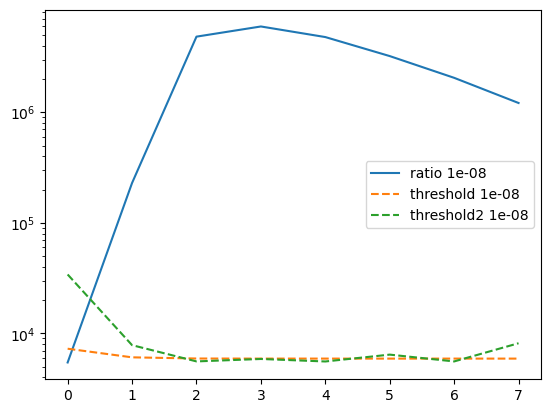

Noise level 	 order 	 	 ratio 	 	 threshold 	 threshold2
1e-07
6.551484449446397e-05
916.5333029089546 0.16799787721738893
C1: 916.5406117697472, C2: 6.223200703127643
	  	 2 	 	 5.456e+03 	 7.906e+03 	 3.620e+04
	  	 3 	 	 2.169e+05 	 7.044e+03 	 9.264e+03
	  	 4 	 	 7.715e+05 	 6.985e+03 	 6.004e+03
	  	 5 	 	 5.737e+05 	 6.982e+03 	 8.944e+03
	  	 6 	 	 4.505e+05 	 6.982e+03 	 6.051e+03
	  	 7 	 	 3.031e+05 	 6.982e+03 	 1.443e+04
	  	 8 	 	 1.957e+05 	 6.982e+03 	 6.099e+03
	  	 9 	 	 1.187e+05 	 6.982e+03 	 3.128e+04


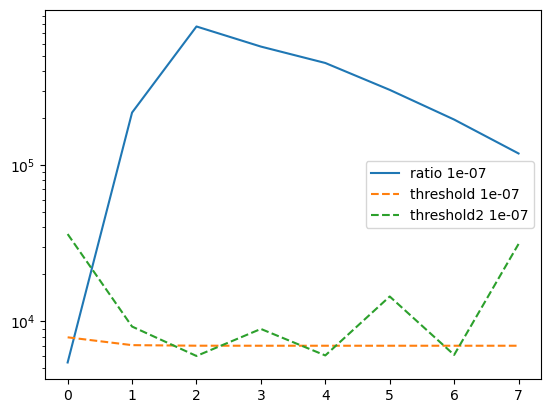

Noise level 	 order 	 	 ratio 	 	 threshold 	 threshold2
1e-06
0.0006504771675555782
916.5332984053222 0.1683039350889578
C1: 916.5555675313528, C2: 6.847682456316162
	  	 2 	 	 5.446e+03 	 1.161e+04 	 4.511e+04
	  	 3 	 	 7.232e+04 	 1.118e+04 	 2.327e+04
	  	 4 	 	 8.018e+04 	 1.115e+04 	 9.492e+03
	  	 5 	 	 5.893e+04 	 1.115e+04 	 4.266e+04
	  	 6 	 	 4.677e+04 	 1.115e+04 	 1.018e+04
	  	 7 	 	 3.190e+04 	 1.115e+04 	 1.044e+05
	  	 8 	 	 2.104e+04 	 1.115e+04 	 1.072e+04
	  	 9 	 	 1.301e+04 	 1.115e+04 	 2.938e+05


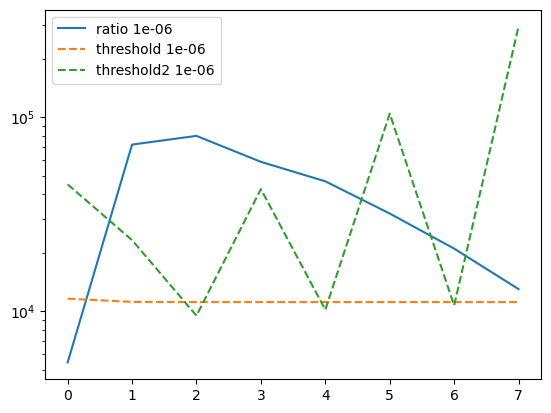

Noise level 	 order 	 	 ratio 	 	 threshold 	 threshold2
1e-05
0.006494188878013701
916.5341830714109 0.1801103199562726
C1: 916.6049998523205, C2: 9.149671688940874
	  	 2 	 	 5.089e+03 	 3.617e+04 	 1.124e+05
	  	 3 	 	 7.617e+03 	 3.592e+04 	 2.699e+05
	  	 4 	 	 7.876e+03 	 3.590e+04 	 6.615e+04
	  	 5 	 	 5.861e+03 	 3.590e+04 	 6.652e+05
	  	 6 	 	 4.741e+03 	 3.590e+04 	 7.894e+04
	  	 7 	 	 3.286e+03 	 3.590e+04 	 1.779e+06
	  	 8 	 	 2.180e+03 	 3.590e+04 	 8.856e+04
	  	 9 	 	 1.345e+03 	 3.590e+04 	 5.200e+06


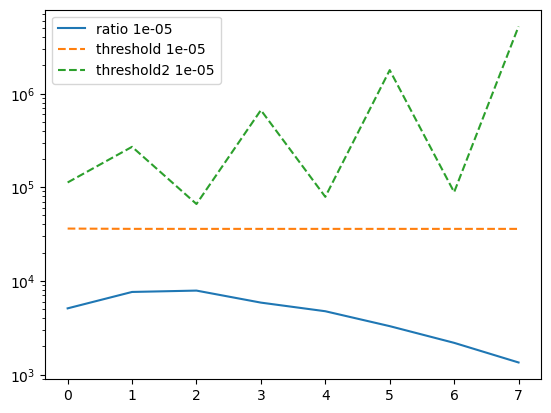

Noise level 	 order 	 	 ratio 	 	 threshold 	 threshold2
0.0001
0.06460998808791127
916.5176248082466 0.7348652479279929
C1: 916.7598742625729, C2: 2.029979576352205
	  	 2 	 	 1.247e+03 	 6.138e+03 	 2.726e+04
	  	 3 	 	 7.814e+02 	 6.134e+03 	 1.499e+05
	  	 4 	 	 8.187e+02 	 6.134e+03 	 3.512e+04
	  	 5 	 	 5.931e+02 	 6.134e+03 	 3.802e+05
	  	 6 	 	 4.626e+02 	 6.134e+03 	 4.251e+04
	  	 7 	 	 3.089e+02 	 6.134e+03 	 1.022e+06
	  	 8 	 	 2.000e+02 	 6.134e+03 	 4.805e+04
	  	 9 	 	 1.228e+02 	 6.134e+03 	 2.993e+06


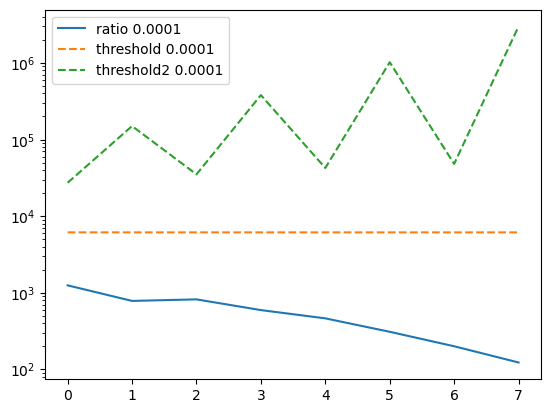

Noise level 	 order 	 	 ratio 	 	 threshold 	 threshold2
0.001
0.6473314240447107
916.4957652562966 7.295039934570313
C1: 917.236706521114, C2: 0.15257628094843656
	  	 2 	 	 1.256e+02 	 2.164e+02 	 1.331e+03
	  	 3 	 	 7.697e+01 	 2.164e+02 	 7.957e+03
	  	 4 	 	 8.074e+01 	 2.164e+02 	 1.898e+03
	  	 5 	 	 6.029e+01 	 2.164e+02 	 2.015e+04
	  	 6 	 	 4.893e+01 	 2.164e+02 	 2.289e+03
	  	 7 	 	 3.338e+01 	 2.164e+02 	 5.409e+04
	  	 8 	 	 2.152e+01 	 2.164e+02 	 2.582e+03
	  	 9 	 	 1.289e+01 	 2.164e+02 	 1.583e+05


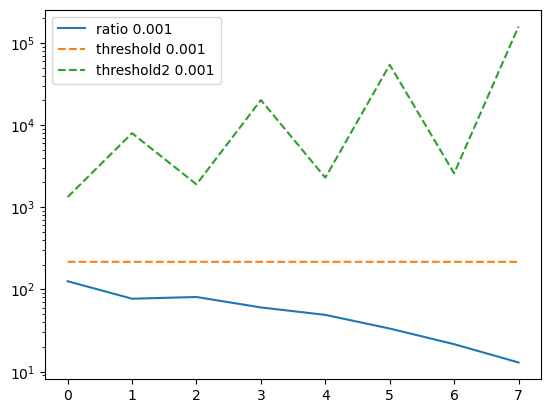

Noise level 	 order 	 	 ratio 	 	 threshold 	 threshold2
0.01
6.373191122710122
919.0328201665819 69.94711845488587
C1: 921.3977033765592, C2: 0.014796787889245442
	  	 2 	 	 1.314e+01 	 1.591e+01 	 1.269e+02
	  	 3 	 	 8.053e+00 	 1.591e+01 	 7.678e+02
	  	 4 	 	 8.664e+00 	 1.591e+01 	 1.833e+02
	  	 5 	 	 6.523e+00 	 1.591e+01 	 1.944e+03
	  	 6 	 	 5.394e+00 	 1.591e+01 	 2.210e+02
	  	 7 	 	 3.812e+00 	 1.591e+01 	 5.220e+03
	  	 8 	 	 2.805e+00 	 1.591e+01 	 2.493e+02
	  	 9 	 	 2.511e+00 	 1.591e+01 	 1.528e+04


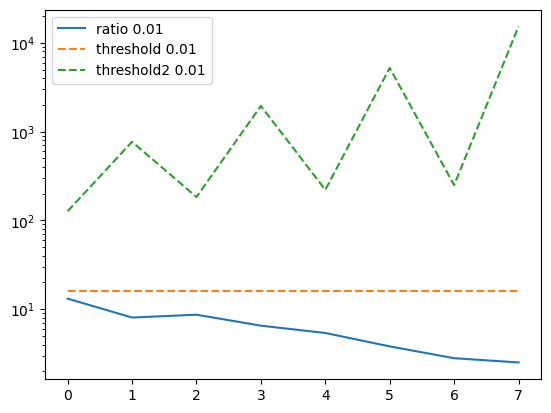

In [11]:
M=infinity_norm(uxxx)
number_noise=10 #<=10
noise_levels = [0]+[10**(-10+i) for i in range(0,number_noise-1)]
orders=range(2,10,1)
print(f"True ratio: {sv_max/sv_min:3.3e}")
unorm2=np.sqrt(np.mean(np.square(u)))


for target_noise in noise_levels:
    print("Noise level \t order \t \t ratio \t \t threshold \t threshold2")
    print(f"{target_noise}")
    
    threshold_list = []
    threshold2_list = []
    ratio_list=[]
    
    var = target_noise * unorm2
    noise = np.random.normal(0, var, size=u.shape)
    print(np.linalg.norm(noise))
    u_noise = u + noise
    eps_two = np.linalg.norm(u-u_noise)
    eps_infty = infinity_norm(u-u_noise)

    #Educated guess for C1 C2
    C1,C2 = educated_guess_c1c2(u_noise,eps_infty,dx)
    print(f"C1: {C1}, C2: {C2}")
    for order in orders:        
        ux_noise = ps.FiniteDifference(order=order,d=1, axis=0, drop_endpoints=False)._differentiate(u_noise, dx)
        u_flat_noise, u_x_flat_noise = u_noise.flatten(), ux_noise.flatten()
        g_noise = np.concatenate([u_flat_noise.reshape(len(u_flat_noise),1), u_x_flat_noise.reshape(len(u_flat_noise),1)], axis=1)
        sv = svd(g_noise, compute_uv=False)
        ratio=sv[0]/sv[-1]
        
        threshold = calc_threshold_uniq(C1,C2,eps_two,dx,order)
        threshold2 = calc_threshold_uniq2(C1,C2,eps_two,eps_infty,M,dx,true_g.shape[0],order)
        threshold_list.append(threshold)
        threshold2_list.append(threshold2)
        ratio_list.append(ratio)

        
        print(f"\t  \t {order} \t \t {ratio:3.3e} \t {threshold:3.3e} \t {threshold2:3.3e}")
    
    plt.plot(ratio_list,label=f'ratio {target_noise}')
    plt.plot(threshold_list,'--',label=f'threshold {target_noise}')
    plt.plot(threshold2_list,'--',label=f'threshold2 {target_noise}')
    plt.yscale('log')
    plt.legend()
    plt.show()

### Combine non uniqueness and uniqueness bound

In [12]:
n_samples=100
T,X,t,x = create_data_2d(T_start=0, T_end=1, L_x_start=-2,L_x_end=3, N_t=n_samples, N_x=n_samples)
a=np.random.randn()
b=np.random.randn()
C=1

u = np.cos(X-a*T)*C
ux = -np.sin(X-a*T)*C
uxx = -np.cos(X-a*T)*C
uxxx = np.sin(X-a*T)*C
ut = a*np.sin(X-a*T)*C

"""
u=(X+b*T)*np.exp(a*T)
ux = np.exp(a*T)
uxx= 1
uxxx= 0
ut= b*np.exp(a*T) + a*(X*+b*T)*np.exp(a*T) #bux + aut

u = np.exp(X-a*T)
ux = u
uxx = u
uxxx = u
ut = -a*u
"""
dx=x[1]-x[0]

u_flat, ux_flat = u.flatten(), ux.flatten()
true_g = np.concatenate([u_flat.reshape(len(u_flat),1), ux_flat.reshape(len(ux_flat),1)], axis=1)
sv = svd(true_g, compute_uv=False)
frobenius_norm_trueg = np.linalg.norm(true_g)
sv_max,sv_min=sv[0],sv[-1]
print(f"M: {np.max(u)}")
print(f"Singular values of g: {sv_max,sv_min}")
print(f"sv_max/sv_min: {sv_max/frobenius_norm_trueg:3.3f}")

M: 0.9999998965619886
Singular values of g: (74.31490940576202, 66.91258655898291)
sv_max/sv_min: 0.743


True ratio: 1.111e+00
Noise level 	 order 	 	 ratio 	 	 threshold 	 threshold2
0
0.0
C: 66.91258655898291, Check 


/tmp/ipykernel_3254974/2408741351.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  return 1/(eps/h+h**order)


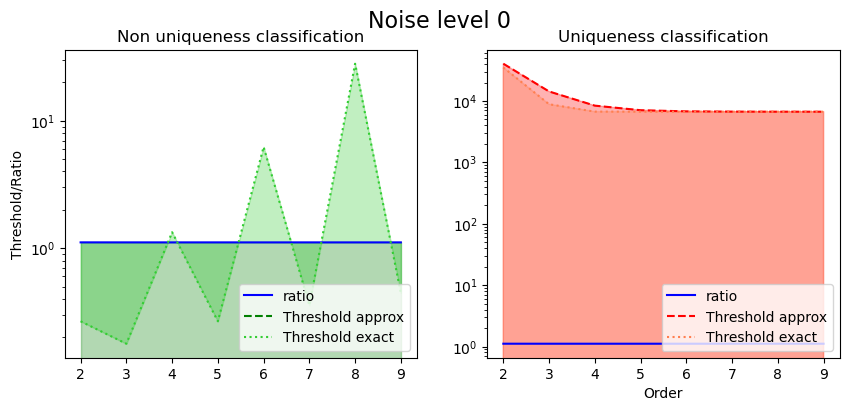

Noise level 	 order 	 	 ratio 	 	 threshold 	 threshold2
1e-10
7.408001427966063e-09
C: 66.91258655898291, Check 


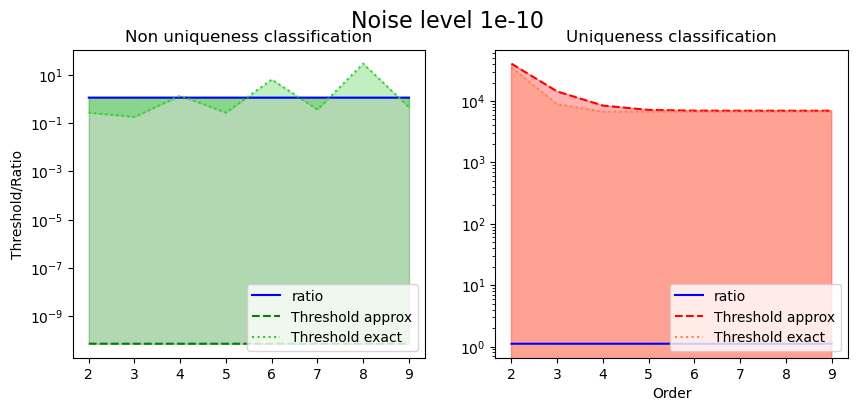

Noise level 	 order 	 	 ratio 	 	 threshold 	 threshold2
1e-09
7.399799967482663e-08
C: 66.91258655898291, Check 


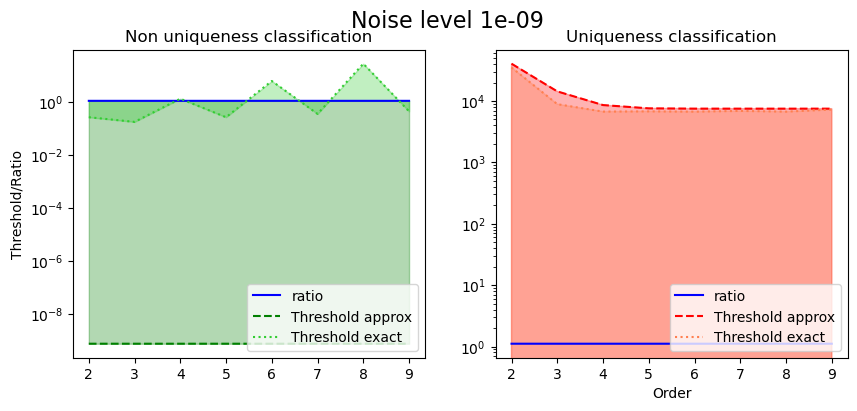

Noise level 	 order 	 	 ratio 	 	 threshold 	 threshold2
1e-08
7.449191612296684e-07
C: 66.91258655898291, Check 


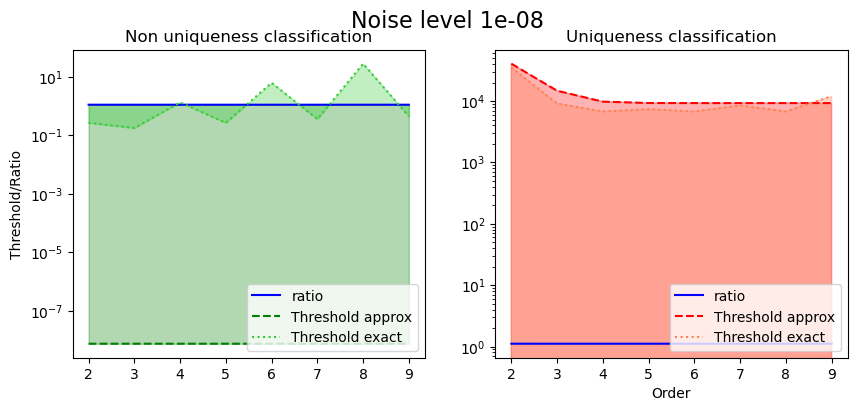

Noise level 	 order 	 	 ratio 	 	 threshold 	 threshold2
1e-07
7.375485294720664e-06
C: 66.91258655898291, Check 


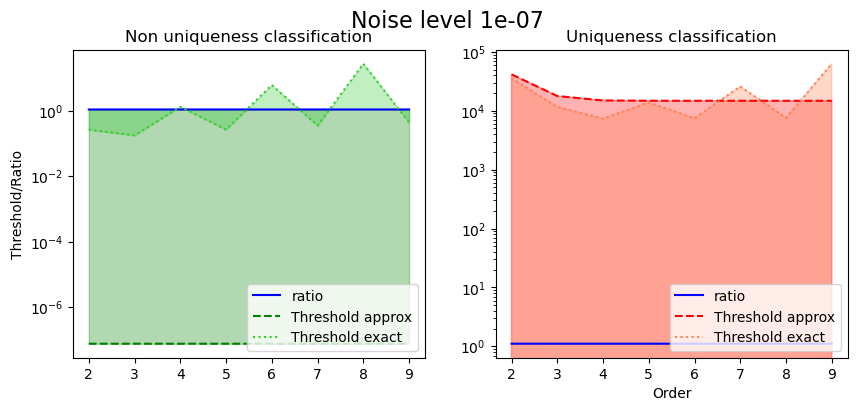

Noise level 	 order 	 	 ratio 	 	 threshold 	 threshold2
1e-06
7.39047277637953e-05
C: 66.91258655898291, Check 


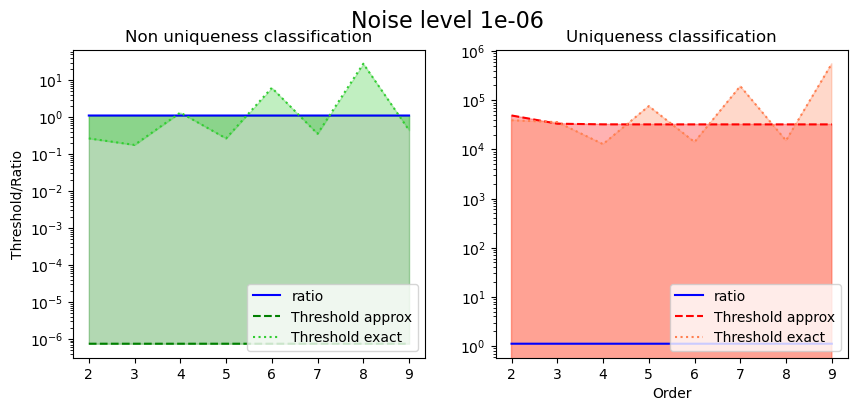

Noise level 	 order 	 	 ratio 	 	 threshold 	 threshold2
1e-05
0.0007445021291004138
C: 66.91258655898291, Check 


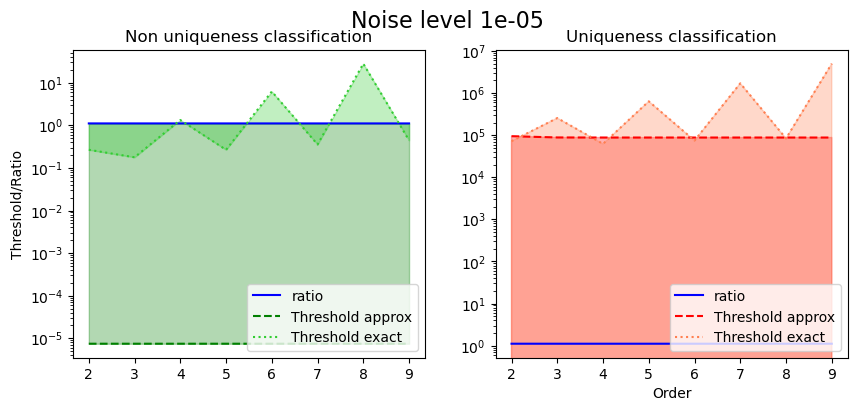

Noise level 	 order 	 	 ratio 	 	 threshold 	 threshold2
0.0001
0.007444654631726922
C: 66.91258655898291, Check 


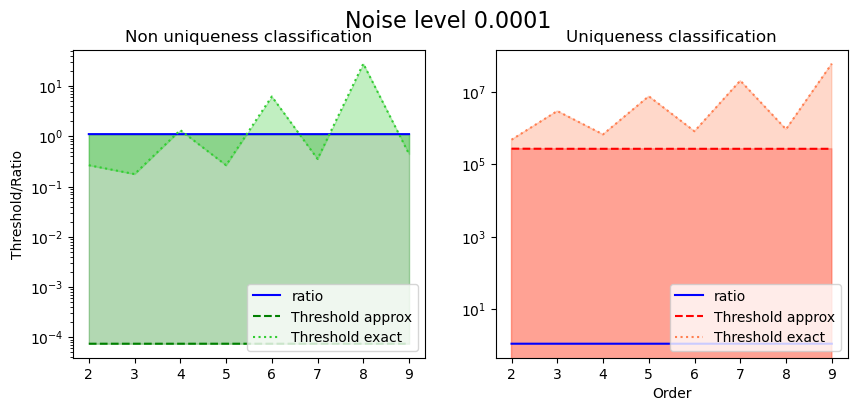

Noise level 	 order 	 	 ratio 	 	 threshold 	 threshold2
0.001
0.07452532186061268
C: 66.91258655898291, Check 


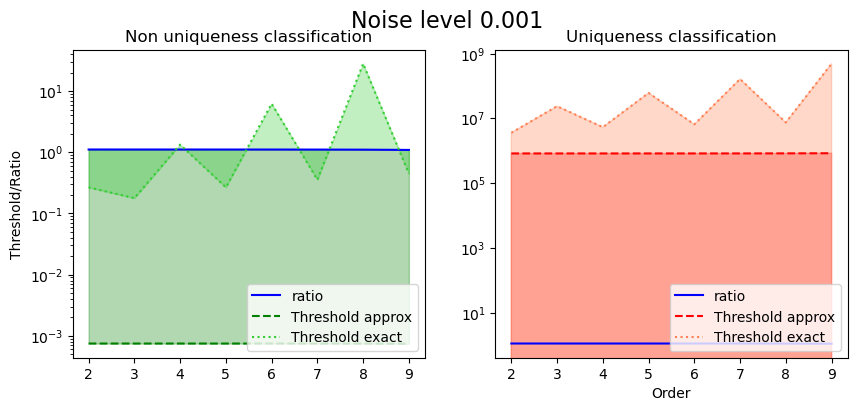

Noise level 	 order 	 	 ratio 	 	 threshold 	 threshold2
0.01
0.7382674660866376
C: 66.91258655898291, Check 


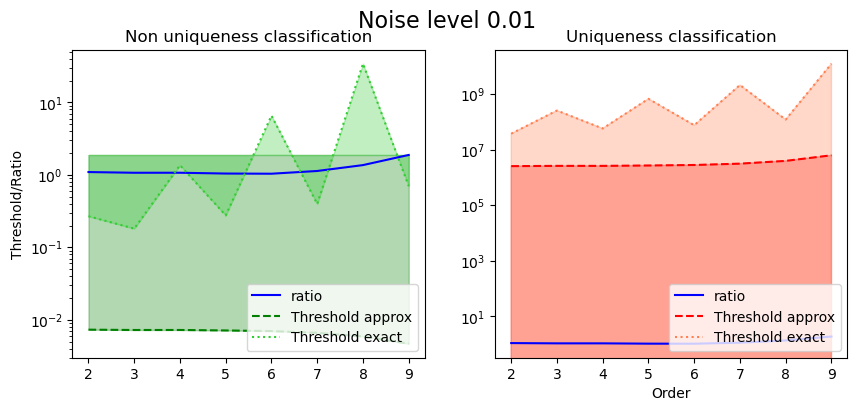

In [13]:
M=infinity_norm(uxxx)
number_noise=10 #<=10
noise_levels = [0]+[10**(-10+i) for i in range(0,number_noise-1)]
orders=range(2,10,1)
print(f"True ratio: {sv_max/sv_min:3.3e}")
unorm2=np.sqrt(np.mean(np.square(u)))
C=sv_min
for target_noise in noise_levels:
    print("Noise level \t order \t \t ratio \t \t threshold \t threshold2")
    print(f"{target_noise}")
    
    threshold_uniq_list = []
    threshold2_uniq_list = []
    threshold_nonunique_list = []
    threshold2_nonunique_list = []
    ratio_list=[]
    
    var = target_noise * unorm2
    noise = np.random.normal(0, var, size=u.shape)
    print(np.linalg.norm(noise))
    u_noise = u + noise
    eps_two = np.linalg.norm(u-u_noise)
    eps_infty = infinity_norm(u-u_noise)

    #Educated guess for C1 C2
    #C = educated_guess_c(u_noise,eps_infty,dx)
    print(f"C: {C}, Check ")
    for order in orders:        
        ux_noise = ps.FiniteDifference(order=order,d=1, axis=0, drop_endpoints=False)._differentiate(u_noise, dx)
        u_flat_noise, u_x_flat_noise = u_noise.flatten(), ux_noise.flatten()
        g_noise = np.concatenate([u_flat_noise.reshape(len(u_flat_noise),1), u_x_flat_noise.reshape(len(u_flat_noise),1)], axis=1)
        sv = svd(g_noise, compute_uv=False)
        frobenius_norm_gnoise=np.linalg.norm(g_noise)
        
        ratio=sv[0]/sv[-1]  
        
        threshold_uniq = calc_threshold_uniq(C,frobenius_norm_gnoise,eps_two,dx,order)
        threshold2_uniq = calc_threshold_uniq2(C,frobenius_norm_gnoise,eps_two,eps_infty,M,dx,true_g.shape[0],order)
        threshold_uniq_list.append(threshold_uniq)
        threshold2_uniq_list.append(threshold2_uniq)
  
        threshold_nonunique = calc_threshold(frobenius_norm_gnoise,eps_two,dx,order)
        threshold2_nonunique = calc_threshold2(frobenius_norm_gnoise,eps_two,eps_infty,M,dx,true_g.shape[0],order)
        threshold_nonunique_list.append(threshold_nonunique)
        threshold2_nonunique_list.append(threshold2_nonunique)
        
        ratio_list.append(ratio)

    # Create subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, figsize=(10, 4))
    fig.suptitle(f'Noise level {target_noise}', fontsize=16)
    
    # Subplot 1: ratio and green lines
    ax1.set_title("Non uniqueness classification")
    ax1.plot(orders, ratio_list, label='ratio', color='blue')
    ax1.plot(orders, threshold_nonunique_list, '--', label='Threshold approx', color='green')
    ax1.plot(orders, threshold2_nonunique_list, ':', label='Threshold exact', color='limegreen')
    ax1.fill_between(orders, threshold_nonunique_list, y2=np.max(ratio_list), color='green', alpha=0.3)
    ax1.fill_between(orders, threshold2_nonunique_list, y2=np.max(ratio_list), color='limegreen', alpha=0.3)
    ax1.set_yscale('log')
    ax1.set_ylabel('Threshold/Ratio')
    
    # Subplot 2: ratio and red lines
    ax2.set_title("Uniqueness classification")
    ax2.plot(orders, ratio_list, label='ratio', color='blue')
    ax2.plot(orders, threshold_uniq_list, '--', label='Threshold approx', color='red')
    ax2.plot(orders, threshold2_uniq_list, ':', label='Threshold exact', color='coral')
    ax2.fill_between(orders, threshold_uniq_list, color='red', alpha=0.3)
    ax2.fill_between(orders, threshold2_uniq_list, color='coral', alpha=0.3)
    ax2.set_yscale('log')

    
    ax2.set_xlabel('Order')
    ax1.legend(loc=4)
    ax2.legend(loc=4)
    
    plt.show()